In [1]:
import os
import sys
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("..")
from src.data.mnist import MNIST
from src.model.sqvae_image import SQVAE
from src.utils import yaml_handler

In [20]:
v = 3
gpu_id = 1
device = f"cuda:{gpu_id}"
checkpoint_dir = f"../models/mnist/version_{v}"
checkpoint_path = sorted(glob(f"{checkpoint_dir}/*.ckpt"))[-1]

# load config
config_path = f"{checkpoint_dir}/mnist.yaml"
config = yaml_handler.load(config_path)

# load model
model = SQVAE(config)
model.configure_model()
model = model.to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

/tmp/ipykernel_2537472/1036950234.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


<All keys matched successfully>

In [21]:
dataset_root = "../data/"
mnist = MNIST(False, root=dataset_root)
dataloader = DataLoader(
    mnist,
    1000,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [22]:
results = []
for x, labels in tqdm(iter(dataloader), total=len(dataloader), ncols=100):
    batch = (x.to(device), labels)
    results += model.predict_step(batch)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


In [23]:
def plot_imgs(imgs, nsamples=100, ncols=10):
    nrows = nsamples // ncols
    fig = plt.figure(figsize=(10, 10))
    axs = fig.subplots(nrows, ncols)
    axs = axs.ravel()
    for i, img in enumerate(imgs[:nsamples]):
        axs[i].imshow(img)
        axs[i].axis("off")

    plt.show()

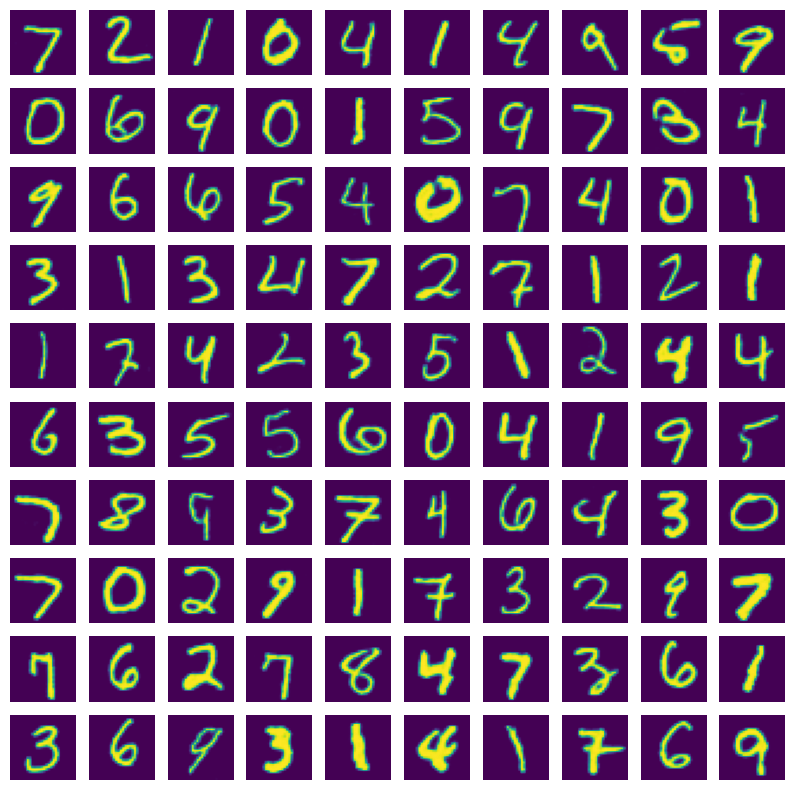

In [24]:
nsamples = 100
# imgs_true = [r["x"] for r in results[:nsamples]]
# plot_imgs(imgs_true, nsamples)
imgs_recon = [r["recon_x"] for r in results[:nsamples]]
plot_imgs(imgs_recon, nsamples)

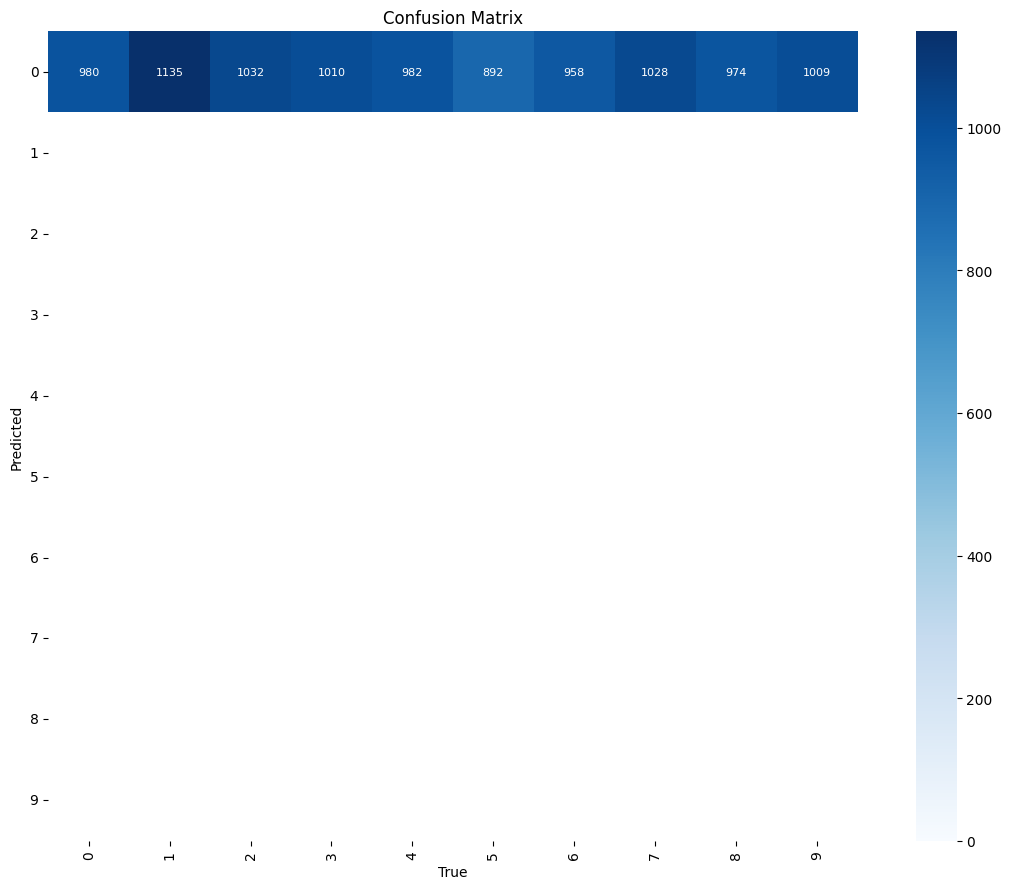

In [25]:
def plot_cm(cm, labels, save_path=None, normalize=False, on_plot=True):
    array = cm / ((cm.sum(0).reshape(1, -1) + 1e-9) if normalize else 1)  # normalize columns
    array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
    ticklabels = labels
    vmax = 1.0 if normalize else None
    sns.heatmap(
        array,
        ax=ax,
        annot=True,
        annot_kws={"size": 8},
        cmap="Blues",
        fmt=".2f" if normalize else ".0f",
        square=True,
        vmin=0.0,
        vmax=vmax,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    ).set_facecolor((1, 1, 1))

    title = "Confusion Matrix" + " Normalized" * normalize
    ax.set_xlabel("True")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("Predicted")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(title)
    if save_path is not None:
        if normalize:
            save_path = save_path.replace(".png", "") + "_normalized.png"
        fig.savefig(save_path, dpi=250)
    if on_plot:
        plt.show()
    plt.close(fig)


labels_pred = np.array([r["label"] for r in results])
labels_gt = np.array([r["label_gt"] for r in results])
cm = confusion_matrix(labels_gt, labels_pred).T
plot_cm(cm, np.arange(config.n_clusters))

In [26]:
labels_prob = np.array([r["label_prob"] for r in results])
labels_prob

array([[0.10300306, 0.09941353, 0.10152703, ..., 0.09827173, 0.10249815,
        0.09651259],
       [0.10300307, 0.09941353, 0.10152704, ..., 0.09827174, 0.10249816,
        0.0965126 ],
       [0.10300355, 0.0994141 , 0.10152721, ..., 0.09827135, 0.10249817,
        0.0965128 ],
       ...,
       [0.10300304, 0.0994135 , 0.10152703, ..., 0.09827176, 0.10249816,
        0.09651259],
       [0.10300304, 0.0994135 , 0.10152703, ..., 0.09827176, 0.10249816,
        0.09651259],
       [0.10300304, 0.0994135 , 0.10152703, ..., 0.09827176, 0.10249816,
        0.09651259]], dtype=float32)

In [27]:
result_gen = []
for i in range(config.n_clusters):
    result_gen += model.sample(i, 10, (7, 7))

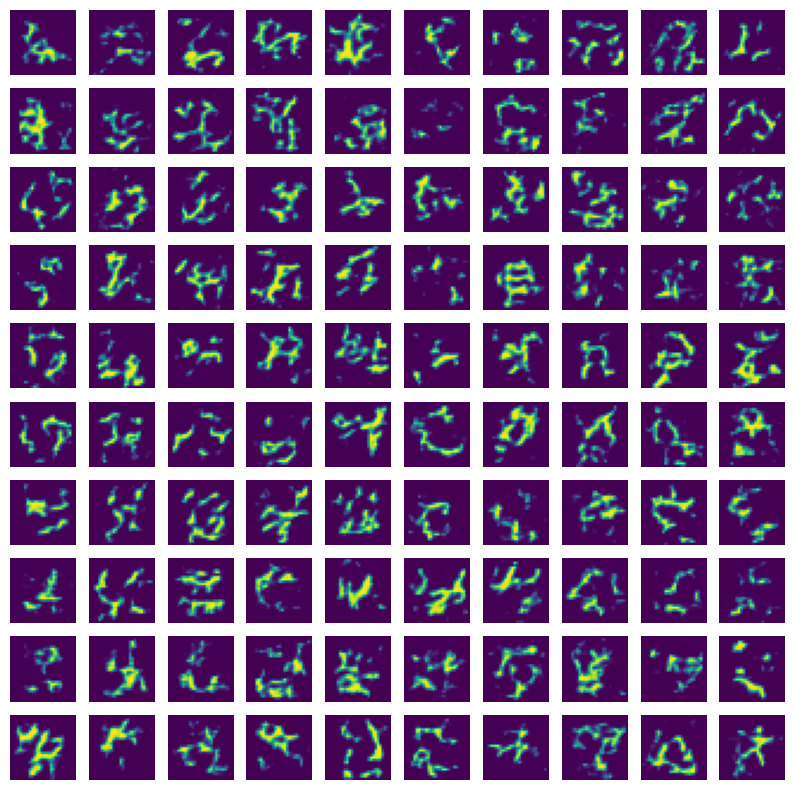

In [28]:
imgs_gen = [r["gen_x"] for r in result_gen]
plot_imgs(imgs_gen, nsamples)